In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, least_squares
from matplotlib import pyplot as plt

In [3]:
def chapman_richards(x, height, age, base_age=50):
    # calculates site index
    si = (
        x[0]
        + height * ((1 - np.exp(-x[1] * base_age)) / (1 - np.exp(-x[1] * age))) ** x[2]
    )
    return si


def chapman_richards_height(x, age, site_index, base_age=50):
    height = (
        site_index
        * ((1 - np.exp(-x[1] * age)) / (1 - np.exp(-x[1] * base_age))) ** x[2]
        - x[0]
    )
    return height


def bailey(x, height, age, base_age):
    si = height * np.exp(x / base_age - x / age)
    return si


def bailey_height(x, age, site_index, base_age=50):
    height = site_index * np.exp(-x / base_age + x / age)
    return height


def powers_1972(x, height, age, base_age=50):
    si = (height + x[0] * (np.sqrt(age) - np.sqrt(base_age))) / (
        1 + x[1] * (np.sqrt(age) - np.sqrt(base_age))
    )
    return si


def powers_1972_height(x, age, site_index, base_age=50):
    height = (site_index * (1 + x[1] * (np.sqrt(age) - np.sqrt(base_age)))) - x[0] * (
        np.sqrt(age) - np.sqrt(base_age)
    )
    return height

In [4]:
def resid(x, height, age, si, **kwargs):
    return chapman_richards(x, height, age, **kwargs) - si


def resid_bailey(x, height, age, si, **kwargs):
    return bailey(x, height, age, **kwargs) - si


def resid_powers(x, height, age, si, **kwargs):
    return powers_1972(x, height, age, **kwargs) - si

In [7]:
DATA = "../data/raw/dunning_reineke_site_index.csv"
df = pd.read_csv(DATA)
# # train = df.loc[(df.tot_age <= 80 )&(df.tot_age >= 40)].copy()
# train = df.loc[df.tot_age <= 80].copy()
train = df.copy()
df.head()

,tot_age,height,bh_age,site_index_50
0,19.610092,10.000000,10.785550,25
1,29.587156,14.848485,20.762615,25
2,39.564220,20.389610,30.739679,25
3,49.541284,25.238095,40.716743,25
4,59.518349,29.740260,50.693807,25


In [8]:
res1 = least_squares(
    resid,
    x0=(4.5, 0.2, 2),
    args=(train.height, train.bh_age, train.site_index_50),
    kwargs={"base_age": 50},
)
res1

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.260e+01  2.901e+00 ...  5.641e-01  1.036e+00]
           x: [-5.002e+00  1.045e-02  1.082e+00]
        cost: 346.8847409908311
         jac: [[ 1.000e+00 -8.085e+02  5.708e+01]
               [ 1.000e+00 -4.566e+02  2.420e+01]
               ...
               [ 1.000e+00  3.717e+03 -7.219e+01]
               [ 1.000e+00  4.071e+03 -7.606e+01]]
        grad: [ 3.980e-06  8.014e-03 -2.465e-03]
  optimality: 0.008014051299142011
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 19
        njev: 15

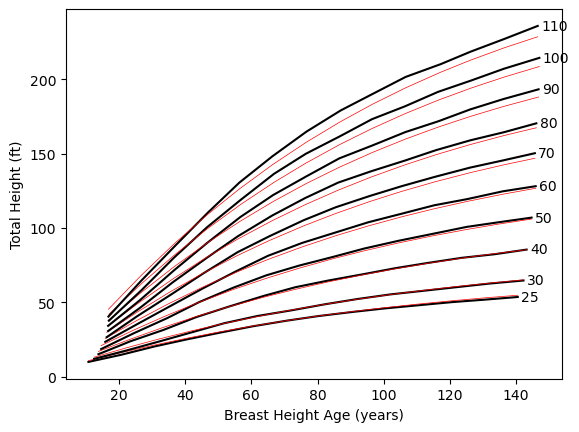

In [9]:
fig, ax = plt.subplots()
for si in np.unique(df.site_index_50):
    data = df.loc[df.site_index_50 == si]
    ax.plot(data.bh_age, data.height, label=si, color="black")
    last = data.iloc[-1]
    ax.text(x=last["bh_age"] + 1, y=last["height"], s=si, ha="left", va="center")
    ax.plot(
        data.bh_age,
        chapman_richards_height(res1.x, data.bh_age, si),
        color="red",
        lw=0.5,
    )
ax.set(xlabel="Breast Height Age (years)", ylabel="Total Height (ft)")
plt.show()

In [10]:
DATA = "../data/raw/powers_oliver_site_index.csv"
df = pd.read_csv(DATA)
df.head()

,tot_age,ht,site_index_50
0,10,5,40
1,15,9,40
2,20,14,40
3,25,20,40
4,30,24,40


In [11]:
res2 = least_squares(
    resid,
    x0=(4.5, 0.2, 2),
    args=(df.ht, df.tot_age, df.site_index_50),
    kwargs={"base_age": 50},
)
res2

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.615e-02 -1.815e+00 ...  3.581e+00  3.879e+00]
           x: [-8.246e-01  2.828e-02  1.872e+00]
        cost: 275.97424776300846
         jac: [[ 1.000e+00 -1.112e+03  4.587e+01]
               [ 1.000e+00 -8.999e+02  3.057e+01]
               ...
               [ 1.000e+00  1.361e+03 -1.877e+01]
               [ 1.000e+00  1.580e+03 -2.103e+01]]
        grad: [-1.763e-07  6.293e-02 -6.525e-03]
  optimality: 0.06293370143248467
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 19
        njev: 14

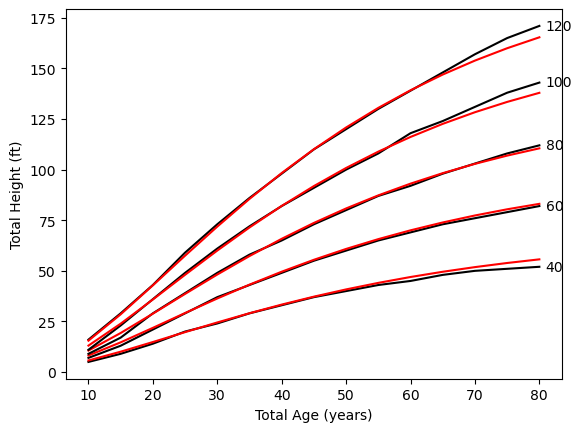

In [13]:
fig, ax = plt.subplots()
for si in np.unique(df.site_index_50):
    data = df.loc[df.site_index_50 == si]
    ax.plot(data.tot_age, data.ht, label=si, color="black")
    last = data.iloc[-1]
    ax.text(x=last["tot_age"] + 1, y=last["ht"], s=si, ha="left", va="center")
    ax.plot(
        data.tot_age,
        chapman_richards_height(res2.x, data.tot_age, si),
        color="red",
    )
ax.set(xlabel="Total Age (years)", ylabel="Total Height (ft)")
plt.show()

In [159]:
DATA = "../data/raw/powers_1972_site_index.csv"
df = pd.read_csv(DATA)
df.head()

,bh_age,height,site_index_50
0,20.259319,21.696751,30
1,29.983793,24.783393,30
2,40.032415,27.707581,30
3,50.081037,30.144404,30
4,60.129660,32.256318,30


In [154]:
res3 = least_squares(
    resid,
    x0=(4.5, 0.2, 2),
    args=(df.height, df.bh_age, df.site_index_50),
    kwargs={"base_age": 50},
)
res3

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.463e+01  7.023e+00 ...  2.759e+00  3.324e+00]
           x: [ 1.764e-01  7.211e-03  8.959e-01]
        cost: 288.0640191134335
         jac: [[ 1.000e+00 -5.424e+02  3.560e+01]
               [ 1.000e+00 -2.987e+02  1.631e+01]
               ...
               [ 1.000e+00  1.087e+03 -3.314e+01]
               [ 1.000e+00  1.342e+03 -3.862e+01]]
        grad: [ 4.171e-08 -1.977e-03  4.687e-04]
  optimality: 0.0019771233937717625
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 19
        njev: 14

In [160]:
res4 = least_squares(
    resid_powers,
    x0=(6.413, 0.322),
    args=(df.height, df.bh_age, df.site_index_50),
    kwargs={"base_age": 50},
)
res4

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.491e-01 -6.979e-02 ...  3.118e-01  3.616e-01]
           x: [ 6.303e+00  3.184e-01]
        cost: 1.038428213626833
         jac: [[-1.414e+01  4.277e+02]
               [-3.242e+00  9.703e+01]
               ...
               [ 1.367e+00 -9.615e+01]
               [ 1.513e+00 -1.065e+02]]
        grad: [ 1.314e-06 -9.942e-05]
  optimality: 9.942286243358467e-05
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 5
        njev: 5

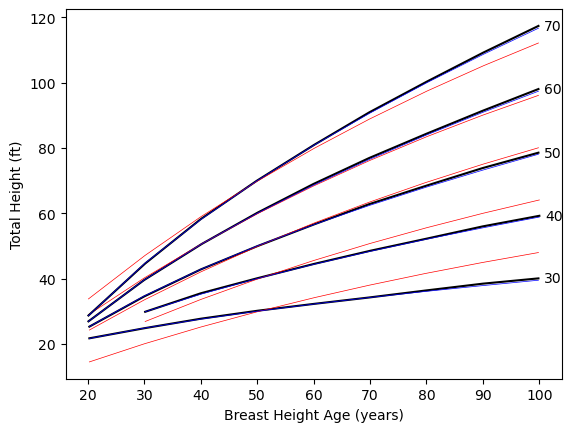

In [161]:
fig, ax = plt.subplots()
for si in np.unique(df.site_index_50):
    data = df.loc[df.site_index_50 == si]
    ax.plot(data.bh_age, data.height, label=si, color="black")
    last = data.iloc[-1]
    ax.text(x=last["bh_age"] + 1, y=last["height"], s=si, ha="left", va="center")
    ax.plot(
        data.bh_age,
        chapman_richards_height(res3.x, data.bh_age, si),
        color="red",
        lw=0.5,
    )
    ax.plot(
        data.bh_age, powers_1972_height(res4.x, data.bh_age, si), color="blue", lw=0.5
    )
ax.set(xlabel="Breast Height Age (years)", ylabel="Total Height (ft)")
plt.show()